## load dependencies

In [19]:
## Initialzing and loading required libraries and subfunctions
import numpy as np
import matplotlib.pyplot as plt
import copy
# import yasa
from mne.filter import resample
import pynapple as nap
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import normalize
import requests
from io import BytesIO
import sails
import re
from scipy.stats import entropy

import scipy
from scipy import signal
from scipy.interpolate import griddata
from scipy.signal import correlate
from scipy.stats import pearsonr
from scipy.fft import fft
from scipy.spatial.distance import euclidean
from scipy.signal import spectrogram
from scipy.io import loadmat
import scipy.fft
import scipy.stats
import scipy.io as sio
from scipy.signal import hilbert

import emd as emd
import emd.sift as sift
import emd.spectra as spectra

from neurodsp.sim import sim_combined
from neurodsp.plts import plot_time_series, plot_timefrequency
from neurodsp.utils import create_times
from neurodsp.timefrequency.wavelets import compute_wavelet_transform
from neurodsp.filt import filter_signal

# Load required libraries
import numpy as np
from scipy.io import loadmat
from scipy.signal import hilbert
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import seaborn as sns
from neurodsp.filt import filter_signal, filter_signal_fir, design_fir_filter
import emd
import pandas as pd
from sklearn.preprocessing import Normalizer
from tqdm import tqdm
import plotly.express as px
import copy
import umap.umap_ as umap
# import skdim
from scipy.spatial import cKDTree
import pickle

## UTILS
from utils import *
from detect_pt import *

from scipy.io import loadmat
import numpy as np
from neurodsp.filt import filter_signal
import copy
import emd
from scipy.spatial import cKDTree
from tqdm import tqdm

sns.set(style='white', context='notebook')

# Ultimate analysis

In [2]:
path_to_hpc = r'C:\Users\Negar\Desktop\Genzel\RGS\1\OS_Ephys_RGS14_Rat1_57986_SD4_HC_01_08_2018\2018-08-01_15-49-15_Post-Trial5\HPC_100_CH4_0.continuous.mat'
path_to_states = r'C:\Users\Negar\Desktop\Genzel\RGS\1\OS_Ephys_RGS14_Rat1_57986_SD4_HC_01_08_2018\2018-08-01_15-49-15_Post-Trial5\2018-08-01_15-49-15_Post-Trial5_concatenated-states.mat'

In [4]:
config = emd.sift.SiftConfig.from_yaml_file('/Users/amir/Desktop/for Abdel/emd_masksift_CA1_config.yml')

In [7]:
lfpHPC, hypno, fs = get_data(path_to_hpc, path_to_states)

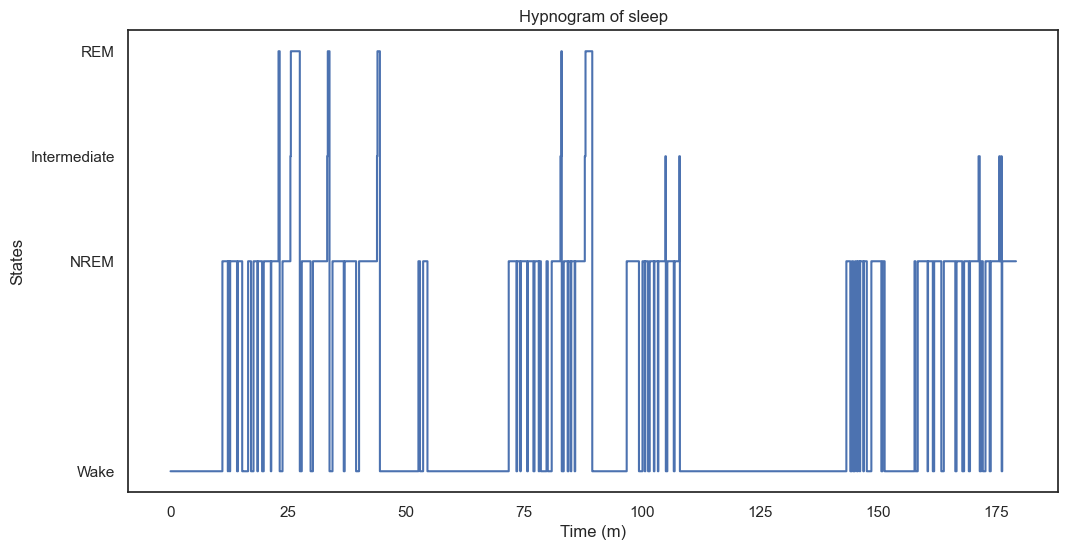

In [8]:
plot_hypnogram(hypno)

In [5]:
def extract_pt_intervals(lfpHPC, hypno, fs=1000):
    targetFs = 500
    n_down = fs / targetFs
    start, end = get_start_end(hypno=hypno, sleep_state_id=5)
    rem_interval = nap.IntervalSet(start=start, end=end)
    fs = int(n_down * targetFs)
    t = np.arange(0, len(lfpHPC) / fs, 1 / fs)
    lfp = nap.TsdFrame(t=t, d=lfpHPC, columns=['HPC'])

    # Detect phasic intervals
    lfpHPC_down = preprocess(lfpHPC, n_down)
    phREM = detect_phasic(lfpHPC_down, hypno, targetFs)

    # Create phasic REM IntervalSet
    start, end = [], []
    for rem_idx in phREM:
        for s, e in phREM[rem_idx]:
            start.append(s / targetFs)
            end.append(e / targetFs)
    phasic_interval = nap.IntervalSet(start, end)

    # Calculate tonic intervals
    tonic_interval = rem_interval.set_diff(phasic_interval)
    print(f'Number of detected Tonic intrevals:{len(tonic_interval)}')
    # Apply a 100 ms duration threshold to tonic intervals
    min_duration = 0.1  # 100 ms in seconds
    durations = tonic_interval['end'] - tonic_interval['start']
    valid_intervals = durations >= min_duration
    tonic_interval = nap.IntervalSet(tonic_interval['start'][valid_intervals], tonic_interval['end'][valid_intervals])
    print(f'Number of detected Tonic intrevals after threshold:{len(tonic_interval)}')
    return phasic_interval, tonic_interval, lfp

In [9]:
phasic_interval, tonic_interval, lfp = extract_pt_intervals(lfpHPC, hypno)

Number of detected Tonic intrevals:11
Number of detected Tonic intrevals after threshold:10


In [10]:
tonic_imfs, tonic_imfs_freqs, tonic_rem_lpf = extract_imfs_by_pt_intervals(lfp, fs, tonic_interval, config, return_imfs_freqs=True)

KeyboardInterrupt: 

In [11]:
phasic_imfs, phasic_imfs_freqs, rem_lpf = extract_imfs_by_pt_intervals(lfp, fs, phasic_interval, config, return_imfs_freqs=True)

In [6]:
def get_cycle_data(imf5, fs=1000):
    cycle_data = {"fs": None, 'theta_imf': None,
                       "IP": None, "IF": None, "IP": None, "cycles": None}


    # Get cycles using IP
    IP, IF, IA = emd.spectra.frequency_transform(imf5, fs, 'hilbert')
    C = emd.cycles.Cycles(IP)
    cycles = get_cycles_with_metrics(C, imf5, IA, IF)

    cycle_data['fs'] = fs
    cycle_data['theta_imf'] = imf5
    cycle_data['IP'] = IP
    cycle_data['IF'] = IF
    cycle_data['IA'] = IA
    cycle_data['cycles'] = cycles
    return cycle_data

In [13]:
start, end = get_start_end(hypno=hypno, sleep_state_id=5)
rem_interval = nap.IntervalSet(start=start, end=end)

# Extract IMFs during REM sleep
rem_imfs, rem_imfs_freqs, rem_lpf = extract_imfs_by_pt_intervals(
    lfp, fs, rem_interval, config, return_imfs_freqs=True
)

In [7]:
# version 1

def prepare_data_for_umap(imfs, imf_frequencies):

  waveforms = pd.DataFrame()
  all_trials = pd.DataFrame()
  all_FPPs = []

  theta_range = [5, 12]
  frequencies = np.arange(15, 141, 1)
  angles=np.linspace(-180,180,19)
  fs = 1000

  for idx, imf in enumerate(imfs):
    cycle_data = get_cycle_data(imf[:, 5], fs=1000)

    amp_thresh = np.percentile(cycle_data['IA'], 25) # higher than 25th percentile of the data
    lo_freq_duration = fs/5  # restrict the analysis to 5-12 Hz
    hi_freq_duration = fs/12

    conditions = ['is_good==1',
                        f'duration_samples<{lo_freq_duration}',
                        f'duration_samples>{hi_freq_duration}',
                        f'max_amp>{amp_thresh}']
    print(len(cycle_data['theta_imf']))
    all_cycles = get_cycles_with_conditions(cycle_data['cycles'], conditions)
    
    # Check if any cycles satisfy the conditions
    if all_cycles is None or all_cycles.chain_vect.size == 0:
        print("No cycles satisfy the conditions.")
        return pd.DataFrame(), pd.DataFrame(), []
    
    subset_cycles_df = all_cycles.get_metric_dataframe(subset=True)
    subset_indices = subset_cycles_df['index'].values

    all_cycles_inds = get_cycle_inds(all_cycles, subset_indices)
    cycles_inds = arrange_cycle_inds(all_cycles_inds)

    freqs = imf_frequencies[idx]
    sub_theta, theta, supra_theta = tg_split(freqs, theta_range)
    supra_theta_sig = np.sum(imf.T[supra_theta], axis=0)

    # # Corrected Wavelet Transform Computation
    raw_data=sails.wavelet.morlet(supra_theta_sig, freqs=frequencies, sample_rate=fs, ncycles=5,ret_mode='power', normalise=None)
    supraPlot = scipy.stats.zscore(raw_data, axis=1)
    FPP = bin_tf_to_fpp(cycles_inds, supraPlot, bin_count=19)
    all_FPPs.append(FPP)

    # Compute mode frequency for each cycle
    mode_freqs, entropies = compute_mode_frequency_and_entropy(FPP, frequencies, angles)

    all_waveforms, _ = emd.cycles.phase_align(cycle_data['IP'], cycle_data['theta_imf'],
                                                            cycles=all_cycles.iterate(through='subset'), npoints=100)
    all_waveforms = pd.DataFrame(all_waveforms.T)

    waveforms = pd.concat([waveforms, all_waveforms])

    trial = all_cycles.get_metric_dataframe(subset=True)
    trial['mode_freqs'] = mode_freqs
    trial['entropy'] = entropies
    all_trials = pd.concat([all_trials, trial])

  return waveforms, all_trials, all_FPPs

In [11]:
def prepare_rem_data_for_umap(imfs, imf_frequencies):
    waveforms = pd.DataFrame()
    all_trials = pd.DataFrame()
    all_FPPs = []

    theta_range = [5, 12]
    frequencies = np.arange(15, 141, 1)
    angles = np.linspace(-180, 180, 19)
    fs = 1000

    for idx, imf in enumerate(imfs):
        cycle_data = get_cycle_data(imf[:, 5], fs=1000)

        amp_thresh = np.percentile(cycle_data['IA'], 25)
        lo_freq_duration = fs/5
        hi_freq_duration = fs/12

        conditions = ['is_good==1',
                      f'duration_samples<{lo_freq_duration}',
                      f'duration_samples>{hi_freq_duration}',
                      f'max_amp>{amp_thresh}']

        all_cycles = get_cycles_with_conditions(cycle_data['cycles'], conditions)

        subset_cycles_df = all_cycles.get_metric_dataframe(subset=True)
        subset_indices = subset_cycles_df['index'].values

        all_cycles_inds = get_cycle_inds(all_cycles, subset_indices)
        cycles_inds = arrange_cycle_inds(all_cycles_inds)

        freqs = imf_frequencies[idx]
        sub_theta, theta, supra_theta = tg_split(freqs, theta_range)
        supra_theta_sig = np.sum(imf.T[supra_theta], axis=0)

        raw_data = sails.wavelet.morlet(supra_theta_sig, freqs=frequencies, sample_rate=fs, ncycles=5, ret_mode='power', normalise=None)
        supraPlot = scipy.stats.zscore(raw_data, axis=1)
        FPP = bin_tf_to_fpp(cycles_inds, supraPlot, bin_count=19)
        all_FPPs.append(FPP)

        mode_freqs, entropies = compute_mode_frequency_and_entropy(FPP, frequencies, angles)

        all_waveforms, _ = emd.cycles.phase_align(cycle_data['IP'], cycle_data['theta_imf'],
                                                  cycles=all_cycles.iterate(through='subset'), npoints=100)
        all_waveforms = pd.DataFrame(all_waveforms.T)

        waveforms = pd.concat([waveforms, all_waveforms])

        trial = all_cycles.get_metric_dataframe(subset=True)
        trial['mode_freqs'] = mode_freqs
        trial['entropy'] = entropies
        all_trials = pd.concat([all_trials, trial])

    return waveforms, all_trials, all_FPPs

In [16]:
rem_waveforms, rem_trials, rem_FPPs = prepare_rem_data_for_umap(rem_imfs, rem_imfs_freqs)

 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking phase_align inputs - trimming singleton from input 'ip'


In [17]:
print(rem_waveforms.shape)

(1705, 100)


In [18]:
rem_waveforms = np.array(rem_waveforms)

In [20]:
ID = np.round(np.nanmean(abids(rem_waveforms, 50)))
np.nanmean(abids(rem_waveforms, 50))

3.159109923540625

In [12]:
ID = 4

In [13]:
def project_cycles(waveforms, embedder):
    return embedder.transform(waveforms)

In [12]:
umap_embedder = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=ID, metric='euclidean', random_state=42)
embedding_rem = umap_embedder.fit_transform(rem_waveforms)

NameError: name 'rem_waveforms' is not defined

In [25]:
embedding_rem.shape

(1705, 4)

In [23]:
phasic_waveforms, phasic_trials, _ = prepare_data_for_umap(phasic_imfs, phasic_imfs_freqs)
tonic_waveforms, tonic_trials, _ = prepare_data_for_umap(tonic_imfs, tonic_imfs_freqs)

phasic_embedding = project_cycles(phasic_waveforms, umap_embedder)
tonic_embedding = project_cycles(tonic_waveforms, umap_embedder)

 Checking Cycles inputs - trimming singleton from input 'IP'
2856
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
1472
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
954
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
2416
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
6048
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
14000
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
87088
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
4358
 Checking

In [27]:
tonic_trials

,index,is_good,duration_samples,peak2trough,asc2desc,max_amp,trough_values,peak_values,mean_if,max_if,range_if,trough_position,peak_position,chain_ind,mode_freqs,entropy
0,1,1,166.0,0.659328,0.523353,320.047091,-318.603634,262.424915,7.528898,10.797400,5.840541,142.0,63.0,0,15,6.716873
1,2,1,126.0,0.564811,0.613688,337.843366,-330.108039,329.726934,9.882312,10.885375,3.101754,96.0,47.0,0,15,6.317242
2,3,1,150.0,0.644905,0.608562,339.514905,-329.408202,321.394459,8.328525,9.974367,3.088352,0.0,64.0,0,15,6.360043
3,4,1,195.0,0.475306,0.426953,313.111292,-312.889799,290.477811,6.409743,9.974367,7.337561,0.0,53.0,0,21,6.787426
4,5,1,177.0,0.526566,0.678011,295.673049,-255.748215,274.049050,7.058372,9.060928,4.914141,122.0,65.0,0,45,6.807021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268,322,1,169.0,0.592770,1.371977,392.343530,-370.440558,355.343454,7.408790,8.141663,1.430987,1.0,64.0,22,40,6.713702
269,323,1,159.0,0.609742,1.368377,354.734215,-330.664588,304.650972,7.877463,8.554297,1.297644,2.0,61.0,22,140,6.716964
270,324,1,159.0,0.658325,1.371884,271.151970,-262.899953,217.142164,7.890129,10.160165,4.481698,1.0,60.0,22,15,6.807835
271,325,1,157.0,0.560981,0.524212,350.322211,-322.446012,282.459965,7.984323,10.160165,3.797365,128.0,53.0,22,105,6.807261


In [28]:
tonic_embedding.shape

(1596, 4)

In [29]:
phasic_embedding.shape

(108, 4)

# Structural Index

In [14]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from structure_index import compute_structure_index

In [14]:
# Set the path to the downloaded repository
repo_path = r"C:\Users\Negar\Desktop\Genzel\Theta-Gamma-Coupling-main2\Theta-Gamma-Coupling-main2\structure_index-main\structure_index-main"  # Replace with the local path on your computer
sys.path.insert(0, repo_path)

In [41]:
tonic_trials

,index,is_good,duration_samples,peak2trough,asc2desc,max_amp,trough_values,peak_values,mean_if,max_if,range_if,trough_position,peak_position,chain_ind,mode_freqs,entropy
0,1,1,166.0,0.659328,0.523353,320.047091,-318.603634,262.424915,7.528898,10.797400,5.840541,142.0,63.0,0,15,6.716873
1,2,1,126.0,0.564811,0.613688,337.843366,-330.108039,329.726934,9.882312,10.885375,3.101754,96.0,47.0,0,15,6.317242
2,3,1,150.0,0.644905,0.608562,339.514905,-329.408202,321.394459,8.328525,9.974367,3.088352,0.0,64.0,0,15,6.360043
3,4,1,195.0,0.475306,0.426953,313.111292,-312.889799,290.477811,6.409743,9.974367,7.337561,0.0,53.0,0,21,6.787426
4,5,1,177.0,0.526566,0.678011,295.673049,-255.748215,274.049050,7.058372,9.060928,4.914141,122.0,65.0,0,45,6.807021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268,322,1,169.0,0.592770,1.371977,392.343530,-370.440558,355.343454,7.408790,8.141663,1.430987,1.0,64.0,22,40,6.713702
269,323,1,159.0,0.609742,1.368377,354.734215,-330.664588,304.650972,7.877463,8.554297,1.297644,2.0,61.0,22,140,6.716964
270,324,1,159.0,0.658325,1.371884,271.151970,-262.899953,217.142164,7.890129,10.160165,4.481698,1.0,60.0,22,15,6.807835
271,325,1,157.0,0.560981,0.524212,350.322211,-322.446012,282.459965,7.984323,10.160165,3.797365,128.0,53.0,22,105,6.807261


In [43]:
tonic_trials['trough_values']

0     -318.603634
1     -330.108039
2     -329.408202
3     -312.889799
4     -255.748215
          ...    
268   -370.440558
269   -330.664588
270   -262.899953
271   -322.446012
272   -360.530868
Name: trough_values, Length: 1596, dtype: float64

In [53]:
np.array(tonic_trials['trough_values']).shape

(1596,)

In [26]:
# Define variables and labels
varList = ['trough_values', 'peak_values', 'entropy']
labelList = [np.array(phasic_trials['trough_values']), np.array(phasic_trials['peak_values']), np.array(phasic_trials['entropy'])]
valLimits = [
    (70, 190),
    (np.percentile(labelList[1], 5), np.percentile(labelList[1], 95)),
    (np.percentile(labelList[2], 5), np.percentile(labelList[2], 95))
]

# Parameters for structure index computation
params = {
    'graph_type': 'weighted',
    'overlap_method': 'continuity',
    'dicrete_bin_label': False,
    'verbose': True,
    'num_shuffles': 10,
    'n_bins': 10,
}

In [38]:
np.array(phasic_waveforms).shape

(108, 100)

In [27]:
# Compute structure index for original data
sI_labels_original = np.empty(len(varList))
sI_shuffle_original = np.empty((params['num_shuffles'], len(varList)))
for v in range(len(varList)):
    print(f'Computing for variable {varList[v]}')
    label = labelList[v]
    params['min_label'], params['max_label'] = valLimits[v]
    sI_labels_original[v], _, _, sI_shuffle_original[:, v] = compute_structure_index(
        np.array(phasic_waveforms), label, n_neighbors=3, **params
    )

Computing for variable trough_values
Computing bin-groups...Computing for variable peak_values
Computing bin-groups..: Done


Computing overlap:   0%|          | 0/45 [00:00<?, ?it/s]

Computing structure index..: 0.81


Computing shuffling:   0%|          | 0/10 [00:00<?, ?it/s]

Shuffling 99th percentile: 0.00
Computing for variable entropy
Computing bin-groups..: Done


Computing overlap:   0%|          | 0/36 [00:00<?, ?it/s]

Computing structure index..: 0.00


Computing shuffling:   0%|          | 0/10 [00:00<?, ?it/s]

Shuffling 99th percentile: 0.02


In [ ]:
print('j1')

In [ ]:
type(phasic_embedding)

In [ ]:
# Compute structure index for reduced data (embedding)
sI_labels_reduced = np.empty(len(varList))
sI_shuffle_reduced = np.empty((params['num_shuffles'], len(varList)))
for v in range(len(varList)):
    print(f'Computing for variable {varList[v]}')
    label = labelList[v]
    params['min_label'], params['max_label'] = valLimits[v]
    sI_labels_reduced[v], _, _, sI_shuffle_reduced[:, v] = compute_structure_index(
        phasic_embedding, label, n_neighbors=3, **params
    )

In [ ]:
# Plotting results
x = np.arange(len(varList))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, sI_labels_original, width, label='Original (127D)')
rects2 = ax.bar(x + width/2, sI_labels_reduced, width, label='Reduced (4D)')

ax.set_ylabel('SI')
ax.set_xticks(x)
ax.set_xticklabels(varList)
ax.legend()

fig.tight_layout()
plt.show()

# whole rat analysis

In [9]:
import os
import pandas as pd
import re

def extract_data_for_rat(rat_id):
    # Define the base path to the RGS dataset
    base_path = '/Users/amir/Desktop/for Abdel/RGS'
    fs = 1000  # Changed sample frequency to 1000

    # Initialize empty DataFrames for concatenation across all recordings and trials for the specified rat
    all_combined_waveforms = pd.DataFrame()
    all_combined_trials = pd.DataFrame()

    # Loop through each top-level condition folder
    conditions = ["HomeCageCG", "RandomCon", "OverlappingOR", "StableCondOD"]
    for condition in conditions:
        condition_path = os.path.join(base_path, condition)
        if not os.path.isdir(condition_path):
            print(f"Condition folder {condition} does not exist.")
            continue
        
        # List all rat folders in the condition folder
        rat_folders = [
            f for f in os.listdir(condition_path)
            if os.path.isdir(os.path.join(condition_path, f)) and f.startswith('OS_Ephys_RGS14_Rat')
        ]

        if not rat_folders:
            print(f"No rat folders found in {condition}.")
            continue

        # Loop over each rat folder in the condition
        for rat_folder in rat_folders:
            print(f"Processing rat folder: {rat_folder}")
            rat_path = os.path.join(condition_path, rat_folder)

            # Use regular expressions to parse the folder name and extract the rat ID (third part after 'Rat')
            match = re.match(r'^OS_Ephys_RGS14_Rat(\d+)_\d+_SD(\d+)_([\w-]+)_([\d-]+)$', rat_folder)
            if not match:
                print(f"Unexpected folder name format: {rat_folder}. Skipping...")
                continue

            rat_id_from_folder = match.group(1)   # Extract rat ID from the folder name (e.g., '1')
            sd_number = match.group(2)             # e.g., '4'
            condition = match.group(3)             # e.g., 'HC'
            date_part = match.group(4)             # e.g., '01_08_2018'

            # Check if the rat ID from folder matches the provided rat ID
            if rat_id_from_folder != str(rat_id):
                print(f"Rat ID mismatch in folder {rat_folder}. Expected Rat{rat_id}, found Rat{rat_id_from_folder}. Skipping...")
                continue

            # Loop through the post-trial folders for this rat, now capturing both underscore and dash formats
            post_trial_folders = [
                f for f in os.listdir(rat_path)
                if os.path.isdir(os.path.join(rat_path, f)) and re.search(r'Post[-_]Trial\d+', f)
            ]

            if not post_trial_folders:
                print(f"No post-trial folders found in {rat_folder}. Skipping...")
                continue

            for post_trial_folder in post_trial_folders:
                print(f"Processing post-trial folder: {post_trial_folder}")
                trial_path = os.path.join(rat_path, post_trial_folder)

                # Search for LFP and state files in the trial folder
                lfp_file = None
                state_file = None

                for file_name in os.listdir(trial_path):
                    if 'HPC_100' in file_name and file_name.endswith('.mat'):  # Look for 'HPC_100'
                        lfp_file = os.path.join(trial_path, file_name)
                    elif 'states' in file_name and file_name.endswith('.mat'):
                        state_file = os.path.join(trial_path, file_name)

                # Ensure both LFP and state files were found
                if not lfp_file or not state_file:
                    print(f"Missing LFP or state file in {trial_path}. Skipping...")
                    continue

                # Extract trial number from folder name, handling both 'Post-Trial' and 'Post_Trial' formats
                trial_number_match = re.search(r'Post[-_]Trial(\d+)', post_trial_folder)
                if trial_number_match:
                    trial_number = int(trial_number_match.group(1))
                else:
                    print(f"Unable to extract trial number from folder name: {post_trial_folder}. Skipping...")
                    continue

                # Load data using custom functions
                try:
                    lfpHPC, hypno, _ = get_data(lfp_file, state_file)

                    # Extract phasic and tonic intervals, handling cases with no REM sleep
                    try:
                        phasic_interval, tonic_interval, lfp = extract_pt_intervals(lfpHPC, hypno, fs=1000)
                    except ValueError as e:
                        print(f"No REM sleep found in {post_trial_folder}. Filling with empty intervals.")
                        phasic_interval, tonic_interval, lfp = [[], [], []]

                    # Extract IMFs and frequencies for phasic and tonic intervals if intervals are not empty
                    if phasic_interval and tonic_interval:
                        tonic_imfs, tonic_freqs, tonic_lpf = extract_imfs_by_pt_intervals(
                            lfp, fs, tonic_interval, config, return_imfs_freqs=True)
                        phasic_imfs, phasic_freqs, phasic_lpf = extract_imfs_by_pt_intervals(
                            lfp, fs, phasic_interval, config, return_imfs_freqs=True)

                        # Prepare UMAP data for both phasic and tonic
                        phasic_waveforms, phasic_trials, _ = prepare_data_for_umap(phasic_imfs, phasic_freqs)
                        tonic_waveforms, tonic_trials, _ = prepare_data_for_umap(tonic_imfs, tonic_freqs)

                        # Add metadata columns, including cycle type labels
                        for df in [phasic_waveforms, phasic_trials]:
                            df['rat_id'] = rat_id
                            df['condition'] = condition
                            df['trial'] = trial_number
                            df['cycle_type'] = 'phasic'
                            df['SD'] = sd_number
                            df['date'] = date_part

                        for df in [tonic_waveforms, tonic_trials]:
                            df['rat_id'] = rat_id
                            df['condition'] = condition
                            df['trial'] = trial_number
                            df['cycle_type'] = 'tonic'
                            df['SD'] = sd_number
                            df['date'] = date_part

                        # Concatenate into combined DataFrames
                        all_combined_waveforms = pd.concat(
                            [all_combined_waveforms, phasic_waveforms, tonic_waveforms], ignore_index=True)
                        all_combined_trials = pd.concat(
                            [all_combined_trials, phasic_trials, tonic_trials], ignore_index=True)

                except FileNotFoundError:
                    print(f"Data not found in {trial_path}. Skipping...")

    if all_combined_waveforms.empty:
        print(f"No data extracted for Rat {rat_id}.")
        return None, None

    return all_combined_waveforms, all_combined_trials

In [12]:
rat_id = '1'  # Replace with the desired rat ID
waveforms_df, trials_df = extract_data_for_rat(rat_id)

Processing rat folder: OS_Ephys_RGS14_Rat9_378134_SD1_HC_29_04_2020
Rat ID mismatch in folder OS_Ephys_RGS14_Rat9_378134_SD1_HC_29_04_2020. Expected Rat1, found Rat9. Skipping...
Processing rat folder: OS_Ephys_RGS14_Rat8_378133_SD1_HC_21_04_2020
Rat ID mismatch in folder OS_Ephys_RGS14_Rat8_378133_SD1_HC_21_04_2020. Expected Rat1, found Rat8. Skipping...
Processing rat folder: OS_Ephys_RGS14_Rat1_57986_SD4_HC_01_08_2018
Processing post-trial folder: 2018-08-01_13-02-00_Post-Trial3
There was 0 in the dataset


Number of detected Tonic intrevals:10
Number of detected Tonic intrevals after threshold:10
 Checking Cycles inputs - trimming singleton from input 'IP'
966
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
998
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
2502
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
1810
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
2400
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
1222
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'


/opt/miniconda3/envs/thetaGamma/lib/python3.10/site-packages/emd/cycles.py:530: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  ensure_equal_dims((ip, x), ('ip', 'x'), 'phase_align')
/opt/miniconda3/envs/thetaGamma/lib/python3.10/site-packages/emd/cycles.py:530: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  ensure_equal_dims((ip, x), ('ip', 'x'), 'phase_align')
/opt/miniconda3/envs/thetaGamma/lib/python3.10/site-packages/emd/cycles.py:530: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  ensure_equal_dims((ip, x), ('ip', 'x'), 'phase_align')
/opt/miniconda3/envs/thetaGamma/lib/python3.10/site-packages/emd/cycles.py:530: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  ensure_equa

10964
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
25070


/opt/miniconda3/envs/thetaGamma/lib/python3.10/site-packages/emd/cycles.py:530: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  ensure_equal_dims((ip, x), ('ip', 'x'), 'phase_align')


 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
54000


/opt/miniconda3/envs/thetaGamma/lib/python3.10/site-packages/emd/cycles.py:530: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  ensure_equal_dims((ip, x), ('ip', 'x'), 'phase_align')


 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
62000


/opt/miniconda3/envs/thetaGamma/lib/python3.10/site-packages/emd/cycles.py:530: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  ensure_equal_dims((ip, x), ('ip', 'x'), 'phase_align')


 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
44690


/opt/miniconda3/envs/thetaGamma/lib/python3.10/site-packages/emd/cycles.py:530: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  ensure_equal_dims((ip, x), ('ip', 'x'), 'phase_align')


 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
10910
 Checking phase_align inputs - trimming singleton from input 'ip'


/opt/miniconda3/envs/thetaGamma/lib/python3.10/site-packages/emd/cycles.py:530: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  ensure_equal_dims((ip, x), ('ip', 'x'), 'phase_align')


 Checking Cycles inputs - trimming singleton from input 'IP'
7612
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'


/opt/miniconda3/envs/thetaGamma/lib/python3.10/site-packages/emd/cycles.py:530: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  ensure_equal_dims((ip, x), ('ip', 'x'), 'phase_align')
/opt/miniconda3/envs/thetaGamma/lib/python3.10/site-packages/emd/cycles.py:530: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  ensure_equal_dims((ip, x), ('ip', 'x'), 'phase_align')


29072
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
9036
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
8748


/opt/miniconda3/envs/thetaGamma/lib/python3.10/site-packages/emd/cycles.py:530: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  ensure_equal_dims((ip, x), ('ip', 'x'), 'phase_align')
/opt/miniconda3/envs/thetaGamma/lib/python3.10/site-packages/emd/cycles.py:530: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  ensure_equal_dims((ip, x), ('ip', 'x'), 'phase_align')


 Checking phase_align inputs - trimming singleton from input 'ip'
Processing post-trial folder: 2018-08-01_13-53-50_Post-Trial4
There was 0 in the dataset


/opt/miniconda3/envs/thetaGamma/lib/python3.10/site-packages/emd/cycles.py:530: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  ensure_equal_dims((ip, x), ('ip', 'x'), 'phase_align')


Number of detected Tonic intrevals:15
Number of detected Tonic intrevals after threshold:15


KeyboardInterrupt: 

In [ ]:
print(waveforms_df.columns)

AttributeError: 'NoneType' object has no attribute 'columns'

In [ ]:
is_phasic = waveforms_df['cycle_type'] == 'phasic'

KeyError: 'cycle_type'

In [ ]:
len([value for i, value in enumerate(is_phasic) if value])

NameError: name 'is_phasic' is not defined

In [20]:
ID = 3

In [ ]:
combined_waveforms = waveforms_df.drop(columns=['treatment', 'rat_id', 'trial', 'cycle_type']).to_numpy() 

AttributeError: 'NoneType' object has no attribute 'drop'

In [17]:
# Apply UMAP to the Combined Waveforms
umap_embedder = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=int(ID), metric='euclidean', random_state=42)
embedding_rem = umap_embedder.fit_transform(combined_waveforms)

NameError: name 'combined_waveforms' is not defined

In [ ]:
# Merge embedding results with trials data to identify phasic and tonic projections
embedding_df = pd.DataFrame(embedding_rem, columns=["UMAP1", "UMAP2", "UMAP3"])
labeled_embedding = pd.concat([embedding_df, trials_df[['cycle_type']].reset_index(drop=True)], axis=1)

# Separate projections for phasic and tonic cycles
tonic_projection = labeled_embedding[labeled_embedding['cycle_type'] == 'tonic'][["UMAP1", "UMAP2", "UMAP3"]].to_numpy()
phasic_projection = labeled_embedding[labeled_embedding['cycle_type'] == 'phasic'][["UMAP1", "UMAP2", "UMAP3"]].to_numpy()

# Plotting the UMAP projections
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# First subplot: UMAP 1 vs UMAP 2
axes[0].scatter(tonic_projection[:, 0], tonic_projection[:, 1], color="blue", s=80, alpha=0.7, label="Tonic Projection", edgecolor='black')
axes[0].scatter(phasic_projection[:, 0], phasic_projection[:, 1], color="orange", s=80, alpha=0.7, marker='X', label="Phasic Projection", edgecolor='black')
axes[0].set_xlabel("UMAP Dimension 1")
axes[0].set_ylabel("UMAP Dimension 2")
axes[0].set_title("UMAP 1 vs UMAP 2")
axes[0].legend()

# Second subplot: UMAP 1 vs UMAP 3
axes[1].scatter(tonic_projection[:, 0], tonic_projection[:, 2], color="blue", s=80, alpha=0.7, label="Tonic Projection", edgecolor='black')
axes[1].scatter(phasic_projection[:, 0], phasic_projection[:, 2], color="orange", s=80, alpha=0.7, marker='X', label="Phasic Projection", edgecolor='black')
axes[1].set_xlabel("UMAP Dimension 1")
axes[1].set_ylabel("UMAP Dimension 3")
axes[1].set_title("UMAP 1 vs UMAP 3")
axes[1].legend()

# Display the plot
plt.suptitle(f"Phasic and Tonic Projections in UMAP cloud - Rat {rat_id}")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(f"UMAP_for_rat_{rat_id}.svg")
plt.show()

TypeError: 'NoneType' object is not subscriptable

# ...

In [ ]:
rat_id = '9'  # Replace with the desired rat ID
waveforms_df, trials_df = extract_data_for_rat(rat_id)

Processing recording folder: OS_Ephys_RGS14_Rat9_378134_SD1_HC_29_04_2020
Processing trial folder: 2020-04-29_12-18-29_Post_Trial2
Number of detected Tonic intrevals:5
Number of detected Tonic intrevals after threshold:4
 Checking Cycles inputs - trimming singleton from input 'IP'
912
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
914
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
1268
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
40658
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
10430
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
6602
 Checking phase_align inputs - trimming singleton fro

In [ ]:
# Prepare features for UMAP embedding
features = waveforms_df.drop(columns=['rat_id', 'condition', 'trial', 'cycle_type', 'SD', 'date'])

# Apply UMAP to the features
umap_embedder = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=3, metric='euclidean', random_state=42)
embedding_rem = umap_embedder.fit_transform(features.to_numpy())

# Create embedding DataFrame
embedding_df = pd.DataFrame(embedding_rem, columns=["UMAP1", "UMAP2", "UMAP3"])

# Combine embeddings with metadata
metadata = waveforms_df[['rat_id', 'condition', 'trial', 'cycle_type', 'SD', 'date']].reset_index(drop=True)
labeled_embedding = pd.concat([embedding_df, metadata], axis=1)

c:\Users\Negar\AppData\Local\Programs\Python\Python38\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


## alignment


In [22]:
# Import custom functions
from structure_index import compute_structure_index, draw_graph

In [23]:
# Rotation and Translation of dataset to align it to another dataset (template) based on a feature
# Arguments:
# data = Dataset of size N to be aligned
# feature = an array of size N representing alignment feature
# template_data = Dataset to which (data) will be aligned
# template_feature = an array representing alignment feature of the template data
def align_point_cloud(data, feature,
                      template_data,
                      template_feature,
                      n_bins=15,
                      n_neighbors=15,
                      dims=None,
                      distance_metric='euclidean',
                      discrete_label=False,
                      num_shuffles=10,
                      verbose=False):
    params = {
        'n_bins': n_bins,
        'n_neighbors': n_neighbors,
        'dims': dims,
        'distance_metric': distance_metric,
        'discrete_label': discrete_label,
        'num_shuffles': num_shuffles,
        'verbose': verbose,
    }

    # Get bins from the data
    SI, binLabel, overlapMat, sSI = compute_structure_index(data, np.array(feature), **params)
    SI_temp, binLabel_temp, overlapMat_temp, sSI_temp = compute_structure_index(template_data, np.array(template_feature), **params)

    # Get centroids of bins (p and p'); these are the points that will be aligned
    p = []
    for i in range(params['n_bins']):
        p.append(np.mean(data[binLabel[0] == i], axis=0))
    p = np.array(p)
    
    p_temp = []
    for i in range(params['n_bins']):
        p_temp.append(np.mean(template_data[binLabel_temp[0] == i], axis=0))
    p_temp = np.array(p_temp)

    # q = p - mean(p)
    # Get deviations of points from their means (q and q'); the Qs are used to get the scatter matrix H
    p_mean = np.mean(p, axis=0)
    p_temp_mean = np.mean(p_temp, axis=0)
    q = p - p_mean
    q_temp = p_temp - p_temp_mean

    # Get Rotation matrix
    H = np.dot(q_temp.T, q)
    U, S, Vh = np.linalg.svd(H, full_matrices=True)
    R = np.dot(U, Vh)
    if np.linalg.det(R) < 0:
        Vh[Vh.shape[0]-1, :] = Vh[Vh.shape[0]-1, :] * (-1)
        R = np.dot(U, Vh)

    T = p_temp_mean - np.dot(p_mean, R)
    new_data = np.dot(data, R) + T
    return new_data

In [24]:
# Function to extract and embed data for a rat
def extract_and_embed_rat(rat_id, umap_params=None):
    """
    Extracts data for a given rat ID and computes UMAP embeddings.

    Parameters:
    - rat_id: str, ID of the rat
    - umap_params: dict, parameters to pass to UMAP

    Returns:
    - embedding: numpy array of shape (n_samples, n_components)
    - waveforms_df: DataFrame containing the waveform data
    - trials_df: DataFrame containing the trials data
    """
    waveforms_df, trials_df = extract_data_for_rat(rat_id)
    if waveforms_df is None or trials_df is None:
        print(f"No data extracted for Rat {rat_id}.")
        return None, None, None

    # Prepare features for UMAP embedding
    features = waveforms_df.drop(columns=['rat_id', 'condition', 'trial', 'cycle_type', 'SD', 'date'])

    # Set default UMAP parameters if not provided
    if umap_params is None:
        umap_params = {'n_neighbors':15, 'min_dist':0.1, 'n_components':3, 'metric':'euclidean', 'random_state':42}

    # Apply UMAP to the features
    umap_embedder = umap.UMAP(**umap_params)
    embedding = umap_embedder.fit_transform(features.to_numpy())

    return embedding, waveforms_df, trials_df


In [1]:
rat_id_ref = '3'  # Reference rat
embedding_ref, waveforms_df_ref, trials_df_ref = extract_and_embed_rat(rat_id_ref)

NameError: name 'extract_and_embed_rat' is not defined

In [ ]:
rat_id_target1 = '1'  # Target rat to be aligned
rat_id_ref = '3'  # Reference rat
embedding_ref, waveforms_df_ref, trials_df_ref = extract_and_embed_rat(rat_id_ref)
# Extract and embed data for target rat
embedding_target1, waveforms_df_target1, trials_df_target1 = extract_and_embed_rat(rat_id_target1)
# Ensure that the features used for alignment are available
alignment_feature_ref = trials_df_ref['trough_values'].values
# alignment_feature_target = trials_df_target['peak_values'].values
alignment_feature_target1 = trials_df_target1['trough_values'].values

# Align embeddings of target rat to reference rat
aligned_embedding_target = align_point_cloud(
    data=embedding_target1,
    feature=alignment_feature_target1,
    template_data=embedding_ref,
    template_feature=alignment_feature_ref,
    n_bins=20,
    n_neighbors=15
)

Processing recording folder: OS_Ephys_RGS14_Rat1_57986_SD1_CON_27-28_07_2018
Processing trial folder: 2018-07-26_11-58-33_Post-Trial2
Number of detected Tonic intrevals:1
Number of detected Tonic intrevals after threshold:1
Processing trial folder: 2018-07-26_12-49-11_Post-Trial3
No REM sleep found in 2018-07-26_12-49-11_Post-Trial3 for Rat 1, Condition CON. Filling with empty intervals.
Processing trial folder: 2018-07-26_13-39-47_Post-Trial4
Number of detected Tonic intrevals:10
Number of detected Tonic intrevals after threshold:9
 Checking Cycles inputs - trimming singleton from input 'IP'
962
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
2248
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
2036
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
994
 

c:\Users\Negar\AppData\Local\Programs\Python\Python38\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [18]:
# Ensure that the features used for alignment are available
alignment_feature_ref = trials_df_ref['trough_values'].values
# alignment_feature_target = trials_df_target['peak_values'].values
alignment_feature_target1 = trials_df_target1['trough_values'].values

In [ ]:
# Align embeddings of target rat to reference rat
aligned_embedding_target = align_point_cloud(
    data=embedding_target1,
    feature=alignment_feature_target1,
    template_data=embedding_ref,
    template_feature=alignment_feature_ref,
    n_bins=20,
    n_neighbors=15
)

# ALL RATS 3D

In [27]:
import plotly.io as pio
pio.renderers.default = "browser"
from structure_index import compute_structure_index, draw_graph
from plotly.graph_objs.layout import Scene
from plotly.graph_objs.layout.scene import XAxis, YAxis, ZAxis
import plotly.graph_objects as go

In [1]:
default_rat_id = '3'  # Replace with the desired rat ID
default_waveforms_df, default_trials_df = extract_data_for_rat(default_rat_id)

default_combined_waveforms = default_waveforms_df.drop(columns=['rat_id', 'condition', 'trial', 'cycle_type', 'SD', 'date'])

umap_embedder = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=4, metric='euclidean', random_state=42)
embedding_rem = umap_embedder.fit_transform(default_combined_waveforms.to_numpy())

target_rat_id1 = '1'  # Replace with the desired rat ID
target_waveforms_df1, target_trials_df1 = extract_data_for_rat(target_rat_id1)

target_combined_waveforms1 = target_waveforms_df1.drop(columns=['rat_id', 'condition', 'trial', 'cycle_type', 'SD', 'date'])

umap_embedder = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=4, metric='euclidean', random_state=42)
target_embedding_rem1 = umap_embedder.fit_transform(target_combined_waveforms1.to_numpy())

defaul_peaks = np.array(default_trials_df['trough_values'])
target_peaks1 = np.array(target_trials_df1['trough_values'])

new_emb1 = align_point_cloud(target_embedding_rem1, target_peaks1, embedding_rem, defaul_peaks,
                                n_bins=20,
                                n_neighbors=15)

NameError: name 'extract_data_for_rat' is not defined

In [2]:
target_rat_id2 = '2'  # Replace with the desired rat ID
target_waveforms_df2, target_trials_df2 = extract_data_for_rat(target_rat_id2)
target_combined_waveforms2 = target_waveforms_df2.drop(columns=['rat_id', 'condition', 'trial', 'cycle_type', 'SD', 'date'])
target_embedding_rem2 = umap_embedder.fit_transform(target_combined_waveforms2.to_numpy())
target_peaks2 = np.array(target_trials_df2['trough_values'])
new_emb2 = align_point_cloud(target_embedding_rem2, target_peaks2, embedding_rem, defaul_peaks,
                                n_bins=20,
                                n_neighbors=15)


target_rat_id4 = '4'  # Replace with the desired rat ID
target_waveforms_df4, target_trials_df4 = extract_data_for_rat(target_rat_id4)
target_combined_waveforms4 = target_waveforms_df4.drop(columns=['rat_id', 'condition', 'trial', 'cycle_type', 'SD', 'date'])
target_embedding_rem4 = umap_embedder.fit_transform(target_combined_waveforms4.to_numpy())
target_peaks4 = np.array(target_trials_df4['trough_values'])
new_emb4 = align_point_cloud(target_embedding_rem4, target_peaks4, embedding_rem, defaul_peaks,
                                n_bins=20,
                                n_neighbors=15)


target_rat_id6 = '6'  # Replace with the desired rat ID
target_waveforms_df6, target_trials_df6 = extract_data_for_rat(target_rat_id6)
target_combined_waveforms6 = target_waveforms_df6.drop(columns=['rat_id', 'condition', 'trial', 'cycle_type', 'SD', 'date'])
target_embedding_rem6 = umap_embedder.fit_transform(target_combined_waveforms6.to_numpy())
target_peaks6 = np.array(target_trials_df6['trough_values'])
new_emb6 = align_point_cloud(target_embedding_rem6, target_peaks6, embedding_rem, defaul_peaks,
                                n_bins=20,
                                n_neighbors=15)


target_rat_id7 = '7'  # Replace with the desired rat ID
target_waveforms_df7, target_trials_df7 = extract_data_for_rat(target_rat_id7)
target_combined_waveforms7 = target_waveforms_df7.drop(columns=['rat_id', 'condition', 'trial', 'cycle_type', 'SD', 'date'])
target_embedding_rem7 = umap_embedder.fit_transform(target_combined_waveforms7.to_numpy())
target_peaks7 = np.array(target_trials_df7['trough_values'])
new_emb7 = align_point_cloud(target_embedding_rem7, target_peaks7, embedding_rem, defaul_peaks,
                                n_bins=20,
                                n_neighbors=15)


target_rat_id8 = '8'  # Replace with the desired rat ID
target_waveforms_df8, target_trials_df8 = extract_data_for_rat(target_rat_id8)
target_combined_waveforms8 = target_waveforms_df8.drop(columns=['rat_id', 'condition', 'trial', 'cycle_type', 'SD', 'date'])
target_embedding_rem8 = umap_embedder.fit_transform(target_combined_waveforms8.to_numpy())
target_peaks8 = np.array(target_trials_df8['trough_values'])
new_emb8 = align_point_cloud(target_embedding_rem8, target_peaks8, embedding_rem, defaul_peaks,
                                n_bins=20,
                                n_neighbors=15)


target_rat_id9 = '9'  # Replace with the desired rat ID
target_waveforms_df9, target_trials_df9 = extract_data_for_rat(target_rat_id9)
target_combined_waveforms9 = target_waveforms_df9.drop(columns=['rat_id', 'condition', 'trial', 'cycle_type', 'SD', 'date'])
target_embedding_rem9 = umap_embedder.fit_transform(target_combined_waveforms9.to_numpy())
target_peaks9 = np.array(target_trials_df9['trough_values'])
new_emb9 = align_point_cloud(target_embedding_rem9, target_peaks9, embedding_rem, defaul_peaks,
                                n_bins=20,
                                n_neighbors=15)

NameError: name 'extract_data_for_rat' is not defined

In [28]:
ID = 3

# NEW

In [8]:
# List of rat IDs to process
rat_ids = [1, 2, 3, 4, 6, 7, 8, 9]

# Initialize lists to hold combined data across all rats
combined_phasic_FPPs = []
combined_tonic_FPPs = []

# Loop through each rat ID and process their data
for rat_id in rat_ids:
    print(f"Processing data for Rat {rat_id}...")
    all_phasic_FPPs, all_tonic_FPPs = extract_data_for_rat(rat_id)
    
    # If data is returned (not None), add it to the combined lists
    if all_phasic_FPPs is not None and all_tonic_FPPs is not None:
        combined_phasic_FPPs.extend(all_phasic_FPPs)
        combined_tonic_FPPs.extend(all_tonic_FPPs)
    else:
        print(f"No data for Rat {rat_id}, skipping...")

Processing data for Rat 1...


NameError: name 'extract_data_for_rat' is not defined

In [7]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import pandas as pd
from structure_index import compute_structure_index, draw_graph


# Rotation and Translation of dataset to align it to another dataset (template) based on a feature
# Arguments:
# data = Dataset of size N to be aligned
# feature = an array of size N representing alignment feature
# template_data = Dataset to which (data) will be aligned
# template_feature = an array representing alignment feature of the template data
def align_point_cloud(data, feature,
                      template_data,
                      template_feature,
                      n_bins=15,
                      n_neighbors=15,
                      dims=None,
                      distance_metric='euclidean',
                      discrete_label=False,
                      num_shuffles=10,
                      verbose=False):
    params = {
        'n_bins': n_bins,
        'n_neighbors': n_neighbors,
        'dims': dims,
        'distance_metric': distance_metric,
        'discrete_label': discrete_label,
        'num_shuffles': num_shuffles,
        'verbose': verbose,
    }

    # Get bins from the data
    SI, binLabel, overlapMat, sSI = compute_structure_index(
        data, np.array(feature), **params)
    SI_temp, binLabel_temp, overlapMat_temp, sSI_temp = compute_structure_index(
        template_data, np.array(template_feature), **params)

    # Get centroids of bins (p and p'); these are the points that will be aligned
    p = []
    for i in range(params['n_bins']):
        p.append(np.mean(data[binLabel[0] == i], axis=0))
    p = np.array(p)

    p_temp = []
    for i in range(params['n_bins']):
        p_temp.append(np.mean(template_data[binLabel_temp[0] == i], axis=0))
    p_temp = np.array(p_temp)

    # q = p - mean(p)
    # Get deviations of points from their means (q and q'); the Qs are used to get the scatter matrix H
    p_mean = np.mean(p, axis=0)
    p_temp_mean = np.mean(p_temp, axis=0)
    q = p - p_mean
    q_temp = p_temp - p_temp_mean

    # Get Rotation matrix
    H = np.dot(q_temp.T, q)
    U, S, Vh = np.linalg.svd(H, full_matrices=True)
    R = np.dot(U, Vh)
    if np.linalg.det(R) < 0:
        Vh[Vh.shape[0]-1, :] = Vh[Vh.shape[0]-1, :] * (-1)
        R = np.dot(U, Vh)

    T = p_temp_mean - np.dot(p_mean, R)
    new_data = np.dot(data, R) + T
    return new_data

    
default_rat_id = '3'  # Replace with the desired rat ID
default_waveforms_df, default_trials_df = extract_data_for_rat(default_rat_id)

default_combined_waveforms = default_waveforms_df.drop(
    columns=['rat_id', 'condition', 'trial', 'cycle_type', 'SD', 'date'])

umap_embedder = umap.UMAP(n_neighbors=15, min_dist=0.1,
                          n_components=4, metric='euclidean', random_state=42)
embedding_rem = umap_embedder.fit_transform(
    default_combined_waveforms.to_numpy())

defaul_peaks = np.array(default_trials_df['peak_values'])

n_bins = 5
n_neighbors = 15
dims = None
distance_metric = 'euclidean'
discrete_label = False
num_shuffles = 10
verbose = True

params = {
    'n_bins': n_bins,
    'n_neighbors': n_neighbors,
    'dims': dims,
    'distance_metric': distance_metric,
    'discrete_label': discrete_label,
    'num_shuffles': num_shuffles,
    'verbose': verbose,
}

SI, binLabel, overlapMat, sSI = compute_structure_index(
    embedding_rem, np.array(defaul_peaks), **params)


# Plot the overlap matrix
plt.figure(figsize=(10, 8))
sns.heatmap(overlapMat, annot=True, fmt=".2f")
plt.title('Overlap Matrix')
plt.xlabel('Bin Group')
plt.ylabel('Bin Group')
plt.show()

# Plot the UMAP embedding colored by bin labels
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    embedding_rem[:, 0], embedding_rem[:, 1], c=binLabel[0], alpha=0.7)
plt.title('UMAP Embedding Colored by Bin Labels')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.colorbar(scatter, label='Bin Label')
plt.show()

# Assuming 'cycle_type' column in default_trials_df indicates 'phasic' or 'tonic'
default_trials_df['bin_label'] = binLabel[0]

# Count the number of phasic and tonic cycles in each bin
phasic_counts = default_trials_df[default_trials_df['cycle_type'] == 'phasic'].groupby(
    'bin_label').size()
tonic_counts = default_trials_df[default_trials_df['cycle_type'] == 'tonic'].groupby(
    'bin_label').size()

# Calculate the density
total_cycles = len(default_trials_df)
phasic_density = phasic_counts / total_cycles
tonic_density = tonic_counts / total_cycles

# Fill missing bins with 0
phasic_density = phasic_density.reindex(range(n_bins), fill_value=0)
tonic_density = tonic_density.reindex(range(n_bins), fill_value=0)

# Plot the densities
plt.figure(figsize=(10, 8))
plt.bar(range(n_bins), phasic_density, alpha=0.7, label='Phasic')
plt.bar(range(n_bins), tonic_density, alpha=0.7,
        label='Tonic', bottom=phasic_density)
plt.xlabel('SI Bin')
plt.ylabel('Density')
plt.title('Density of Phasic and Tonic Cycles in Each SI Bin')
plt.legend()
plt.show()


# Assuming 'cycle_type' column in default_trials_df indicates 'phasic' or 'tonic'
default_trials_df['bin_label'] = binLabel[0]

# Count the number of phasic and tonic cycles in each bin
phasic_counts = default_trials_df[default_trials_df['cycle_type'] == 'phasic'].groupby(
    'bin_label').size()
tonic_counts = default_trials_df[default_trials_df['cycle_type'] == 'tonic'].groupby(
    'bin_label').size()

# Fill missing bins with 0
phasic_counts = phasic_counts.reindex(range(n_bins), fill_value=0)
tonic_counts = tonic_counts.reindex(range(n_bins), fill_value=0)

# Calculate the percentage for each bin
total_counts = phasic_counts + tonic_counts
phasic_percentage = (phasic_counts / total_counts) * 100
tonic_percentage = (tonic_counts / total_counts) * 100

# Setup the grouped bar plot
x = np.arange(n_bins)       # the label locations
width = 0.35                # the width of the bars

plt.figure(figsize=(10, 8))
plt.bar(x - width/2, phasic_percentage, width, alpha=0.7, label='Phasic')
plt.bar(x + width/2, tonic_percentage, width, alpha=0.7, label='Tonic')

plt.xlabel('SI Bin')
plt.ylabel('Percentage')
plt.title('Percentage of Phasic and Tonic Cycles in Each SI Bin')
plt.xticks(x, [f"Bin {i}" for i in x])
plt.legend()
plt.show()


NameError: name 'extract_data_for_rat' is not defined

# Control vs. Pos

In [3]:
# List of control and POS rat IDs
controlRats = ['1', '2', '6', '9']  # Replace with actual control rat IDs
posRats = ['3', '4', '7', '8']  # Replace with actual POS rat IDs

# Initialize lists to store the combined data for control and POS rats
all_waveforms = pd.DataFrame()
all_trials = pd.DataFrame()


# Extract and append the waveforms for control rats
for rat_id in controlRats:
    waveforms_df, trials_df = extract_data_for_rat(rat_id)
    waveforms_df['dataset'] = 'RGS_control'
    trials_df['dataset'] = 'RGS_control'

    # Concatenate to main dataframes
    all_waveforms = pd.concat([all_waveforms, waveforms_df], ignore_index=True)
    all_trials = pd.concat([all_trials, trials_df], ignore_index=True)

# # Extract and append the waveforms for POS rats
# for rat_id in posRats:
#     target_waveforms_df, target_trials_df = extract_data_for_rat(rat_id)
#     target_combined_waveforms = target_waveforms_df.drop(columns=['rat_id', 'condition', 'trial', 'cycle_type', 'SD', 'date'])
#     pos_waveforms_list.append(target_combined_waveforms)

# # Combine the control and POS waveforms into a single DataFrame
# control_combined_waveforms = pd.concat(control_waveforms_list, axis=0)
# pos_combined_waveforms = pd.concat(pos_waveforms_list, axis=0)

# # Combine both control and POS waveforms into one dataset
# combined_waveforms = pd.concat([control_combined_waveforms, pos_combined_waveforms], axis=0)




NameError: name 'pd' is not defined

In [4]:
# Extract and append the waveforms for control rats
for rat_id in posRats:
    waveforms_df, trials_df = extract_data_for_rat(rat_id)
    waveforms_df['dataset'] = 'RGS_pos'
    trials_df['dataset'] = 'RGS_pos'

    # Concatenate to main dataframes
    all_waveforms = pd.concat([all_waveforms, waveforms_df], ignore_index=True)
    all_trials = pd.concat([all_trials, trials_df], ignore_index=True)

NameError: name 'extract_data_for_rat' is not defined

In [50]:
import numpy as np
from matplotlib.colors import Normalize

# 1) Build your masks
pos_mask     = (datasets == 'RGS_pos')
control_mask = (datasets == 'RGS_control')

# 2) Compute a global vmin/vmax over all RGS points
all_mask = pos_mask | control_mask
vmin_all = np.percentile(peak_values[all_mask], 5)
vmax_all = np.percentile(peak_values[all_mask], 95)
norm_all = Normalize(vmin=vmin_all, vmax=vmax_all)

# Now pass norm_all into both your POS and control plots…


In [55]:
ID

3

In [35]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd

# Assuming all_waveforms and all_trials have been created from the previous script
# Make sure both datasets actually have data before proceeding

# First, let's check if the OS Basic data exists
print(f"OS Basic data points: {sum(all_waveforms['dataset'] == 'RGS_Control')}")
print(f"RGS Control data points: {sum(all_waveforms['dataset'] == 'RGS_pos')}")

# If there's an issue with OS Basic data, ensure extraction was successful
# For now, let's proceed with the improved visualization

# Step 1: Drop metadata columns for UMAP processing (keep only the waveform data)
waveforms_for_umap = all_waveforms.drop(columns=['rat_id', 'condition', 'trial', 'cycle_type', 'SD', 'date', 'dataset'], errors='ignore')

# Step 2: Create UMAP model with 3 components for both 2D and 3D visualization
print("Creating UMAP embedding...")
umap_embedder = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=3, metric='euclidean', random_state=42)
embedding = umap_embedder.fit_transform(waveforms_for_umap.to_numpy())

OS Basic data points: 0
RGS Control data points: 125970
Creating UMAP embedding...


c:\Users\Negar\AppData\Local\Programs\Python\Python38\lib\site-packages\umap\umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [43]:
# import numpy as np
# import pandas as pd
# import umap
# import plotly.graph_objects as go

# # Step 1: Create masks for each dataset
# control_mask = all_waveforms['dataset'] == 'RGS_control'
# pos_mask = all_waveforms['dataset'] == 'RGS_pos'

# # Step 2: Get peak values (assuming alignment between all_trials and all_waveforms)
# peak_values = all_trials['peak_values'].values

# # Step 3: Compute color limits (5th to 95th percentiles) for each dataset.
# # For Control
# if np.sum(control_mask) > 0:
#     vmin_control = np.percentile(peak_values[control_mask], 5)
#     vmax_control = np.percentile(peak_values[control_mask], 95)
# else:
#     vmin_control = np.min(peak_values)
#     vmax_control = np.max(peak_values)

# # For POS
# if np.sum(pos_mask) > 0:
#     vmin_pos = np.percentile(peak_values[pos_mask], 5)
#     vmax_pos = np.percentile(peak_values[pos_mask], 95)
# else:
#     vmin_pos = np.min(peak_values)
#     vmax_pos = np.max(peak_values)

# # Step 4: Compute 3D UMAP embedding from all waveforms.
# # Convert your DataFrame to numpy array (all_waveforms should be numerical or preprocessed accordingly)
# umap_embedder = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=3,
#                           metric='euclidean', random_state=42)
combined_embedding = umap_embedder.fit_transform(all_waveforms.to_numpy())

# Step 5: Create 3D scatter traces using Plotly with separate color mappings.

# Trace for Control dataset (using a Blue color scale)
scatter_control = go.Scatter3d(
    x=combined_embedding[control_mask, 0],
    y=combined_embedding[control_mask, 1],
    z=combined_embedding[control_mask, 2],
    mode='markers',
    marker=dict(
        size=5,
        color=peak_values[control_mask],
        colorscale='Blues',
        cmin=vmin_control,
        cmax=vmax_control,
        opacity=0.8,
        colorbar=dict(title='Control RGS Peak Values', len=0.5, x=0)  # Positioning the colorbar on the left
    ),
    name=f'OS Basic (n={np.sum(control_mask)})'
)

# Trace for POS dataset (using a Red color scale)
scatter_pos = go.Scatter3d(
    x=combined_embedding[pos_mask, 0],
    y=combined_embedding[pos_mask, 1],
    z=combined_embedding[pos_mask, 2],
    mode='markers',
    marker=dict(
        size=5,
        color=peak_values[pos_mask],
        colorscale='Reds',
        cmin=vmin_pos,
        cmax=vmax_pos,
        opacity=0.8,
        colorbar=dict(title='POS RGS Peak Values', len=0.5, x=1.0)  # Positioning the colorbar on the right
    ),
    name=f'RGS Control (n={np.sum(pos_mask)})'
)

# Step 6: Combine both scatter traces into a single figure and update the layout.
fig = go.Figure(data=[scatter_control, scatter_pos])
fig.update_layout(
    title="UMAP Visualization of Theta Cycles by Dataset (3D)",
    autosize=False,
    width=800,
    height=600,
    scene=dict(
        xaxis=dict(title='UMAP Dimension 1'),
        yaxis=dict(title='UMAP Dimension 2'),
        zaxis=dict(title='UMAP Dimension 3')
    )
)

# Step 7: Display the figure and save as an HTML file.
fig.show()
fig.write_html("Rat_3D_UMAPNEW.html")


ValueError: could not convert string to float: 'CON'

In [26]:
# UMAP Embedding
umap_embedder = umap.UMAP(n_neighbors=15, min_dist=0.1,
                          n_components=4, metric='euclidean', random_state=42)  # 3D UMAP

# Perform UMAP on the combined data
combined_embedding = umap_embedder.fit_transform(combined_waveforms.to_numpy())

# Create labels for the plot (Control = 0, POS = 1)
labels = [0] * len(control_combined_waveforms) + [1] * len(pos_combined_waveforms)

# Scatter plot for Control rats (label = 0)
scatter1 = go.Scatter3d(
    x=combined_embedding[:len(control_combined_waveforms), 0],
    y=combined_embedding[:len(control_combined_waveforms), 1],
    z=combined_embedding[:len(control_combined_waveforms), 2],
    mode='markers',
    marker=dict(size=5, color='blue', opacity=0.8),
    name='Control'
)

# Scatter plot for POS rats (label = 1)
scatter2 = go.Scatter3d(
    x=combined_embedding[len(control_combined_waveforms):, 0],
    y=combined_embedding[len(control_combined_waveforms):, 1],
    z=combined_embedding[len(control_combined_waveforms):, 2],
    mode='markers',
    marker=dict(size=5, color='red', opacity=0.8),
    name='POS'
)

# Combine both scatter plots into a single figure
fig = go.Figure(data=[scatter1, scatter2])

# Update the layout of the figure
fig.update_layout(
    title="Control vs POS Rats - 3D UMAP",
    autosize=False,
    width=800,
    height=600,
    scene=dict(
        xaxis=dict(title='UMAP-1'),
        yaxis=dict(title='UMAP-2'),
        zaxis=dict(title='UMAP-3')
    )
)

# Show the figure
fig.show()

# Save the plot as an HTML file
fig.write_html("Rat_3D_UMAP.html")

KeyboardInterrupt: 

In [ ]:
import plotly.graph_objects as go
import umap
import pandas as pd
import numpy as np

# UMAP Embedding
umap_embedder = umap.UMAP(n_neighbors=15, min_dist=0.1,
                          n_components=4, metric='euclidean', random_state=42)  # 4D UMAP

# Perform UMAP on the combined data
combined_embedding = umap_embedder.fit_transform(combined_waveforms.to_numpy())

# Create labels for the plot (Control = 0, POS = 1)
labels = [0] * len(control_combined_waveforms) + [1] * len(pos_combined_waveforms)

# Separate embeddings for control and POS rats
control_embedding = combined_embedding[:len(control_combined_waveforms)]
pos_embedding = combined_embedding[len(control_combined_waveforms):]

# Scatter plot for Control rats (label = 0)
scatter1 = go.Scatter3d(
    x=control_embedding[:, 0],
    y=control_embedding[:, 1],
    z=control_embedding[:, 2],
    mode='markers',
    marker=dict(size=5, color='blue', opacity=0.6),  # Set opacity for Control
    name='Control'
)

# Scatter plot for POS rats (label = 1)
scatter2 = go.Scatter3d(
    x=pos_embedding[:, 0],
    y=pos_embedding[:, 1],
    z=pos_embedding[:, 2],
    mode='markers',
    marker=dict(size=5, color='red', opacity=0.8),  # Set opacity for POS
    name='POS'
)

# Combine both scatter plots into a single figure
fig = go.Figure(data=[scatter1, scatter2])

# Update the layout of the figure
fig.update_layout(
    title="Control vs POS Rats - 3D UMAP",
    autosize=False,
    width=800,
    height=600,
    scene=dict(
        xaxis=dict(title='UMAP-1'),
        yaxis=dict(title='UMAP-2'),
        zaxis=dict(title='UMAP-3')
    )
)

# Show the figure
fig.show()

# Save the combined plot as an HTML file
fig.write_html("Rat_3D_UMAP_combined.html")

# Separate UMAPs: Control only
scatter_control_only = go.Scatter3d(
    x=control_embedding[:, 0],
    y=control_embedding[:, 1],
    z=control_embedding[:, 2],
    mode='markers',
    marker=dict(size=5, color='blue', opacity=0.8),
    name='Control'
)

# Separate UMAP: POS only
scatter_pos_only = go.Scatter3d(
    x=pos_embedding[:, 0],
    y=pos_embedding[:, 1],
    z=pos_embedding[:, 2],
    mode='markers',
    marker=dict(size=5, color='red', opacity=0.8),
    name='POS'
)

# Create a figure for Control only
fig_control = go.Figure(data=[scatter_control_only])
fig_control.update_layout(
    title="Control Rats - 3D UMAP",
    autosize=False,
    width=800,
    height=600,
    scene=dict(
        xaxis=dict(title='UMAP-1'),
        yaxis=dict(title='UMAP-2'),
        zaxis=dict(title='UMAP-3')
    )
)

# Create a figure for POS only
fig_pos = go.Figure(data=[scatter_pos_only])
fig_pos.update_layout(
    title="POS Rats - 3D UMAP",
    autosize=False,
    width=800,
    height=600,
    scene=dict(
        xaxis=dict(title='UMAP-1'),
        yaxis=dict(title='UMAP-2'),
        zaxis=dict(title='UMAP-3')
    )
)

# Show individual figures
fig_control.show()
fig_pos.show()

# Save individual UMAPs as HTML files
fig_control.write_html("Control_3D_UMAP.html")
fig_pos.write_html("POS_3D_UMAP.html")


c:\Users\Negar\AppData\Local\Programs\Python\Python38\lib\site-packages\umap\umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



# Different Embeddings

In [2]:
# List of control and POS rat IDs
controlRats = ['1', '2', '6', '9']  # Replace with actual control rat IDs
posRats = ['3', '4', '7', '8']  # Replace with actual POS rat IDs

# Initialize lists to store the combined data for control and POS rats
all_waveforms = pd.DataFrame()
all_trials = pd.DataFrame()


# Extract and append the waveforms for control rats
for rat_id in controlRats:
    waveforms_df, trials_df = extract_data_for_rat(rat_id)
    waveforms_df['dataset'] = 'RGS_control'
    trials_df['dataset'] = 'RGS_control'

    # Concatenate to main dataframes
    all_waveforms = pd.concat([all_waveforms, waveforms_df], ignore_index=True)
    all_trials = pd.concat([all_trials, trials_df], ignore_index=True)

NameError: name 'pd' is not defined

In [6]:
# Extract and append the waveforms for control rats
for rat_id in posRats:
    waveforms_df, trials_df = extract_data_for_rat(rat_id)
    waveforms_df['dataset'] = 'RGS_pos'
    trials_df['dataset'] = 'RGS_pos'

    # Concatenate to main dataframes
    all_waveforms = pd.concat([all_waveforms, waveforms_df], ignore_index=True)
    all_trials = pd.concat([all_trials, trials_df], ignore_index=True)

NameError: name 'extract_data_for_rat' is not defined

In [33]:
all_waveforms.to_csv('all_waveforms.csv', index=False)

In [35]:
all_waveforms = pd.read_csv('all_waveforms.csv', low_memory=False)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from umap import UMAP
import plotly.express as px
import plotly.io as pio

# Use browser for interactive plot rendering
pio.renderers.default = 'browser'

# — prepare feature matrix columns —
meta_cols    = ['rat_id','condition','trial','cycle_type','SD','date','dataset']
feature_cols = [c for c in all_waveforms.columns if c not in meta_cols]

# — define masks for each dataset —
control_mask = (all_waveforms['dataset'] == 'RGS_control')
pos_mask     = (all_waveforms['dataset'] == 'RGS_pos')

# — compute a shared color scale across both datasets —
peaks_ctrl = all_trials.loc[control_mask, 'peak_values'].values
peaks_pos  = all_trials.loc[pos_mask,    'peak_values'].values
all_peaks  = np.concatenate([peaks_ctrl, peaks_pos])
vmin, vmax = np.percentile(all_peaks, [5, 95])
norm       = Normalize(vmin=vmin, vmax=vmax)
cmap       = plt.get_cmap('viridis')

def embed_and_save(mask, label):
    # build feature array & extract peaks/cycle types
    X      = all_waveforms.loc[mask, feature_cols].values
    peaks  = all_trials.loc[mask, 'peak_values'].values
    cycles = all_waveforms.loc[mask, 'cycle_type'].values
    tonic  = (cycles == 'tonic')
    phasic = (cycles == 'phasic')

    # — compute 3‐component UMAP once —
    # umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=ID, metric='euclidean', random_state=42)
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=3, metric='euclidean', random_state=42)
    emb3    = reducer.fit_transform(X)

    # # — 2D static plot (first two components) —
    # fig, ax = plt.subplots(figsize=(8, 6))
    # if tonic.any():
    #     sc = ax.scatter(
    #         emb3[tonic, 0], emb3[tonic, 1],
    #         c=peaks[tonic], cmap=cmap, norm=norm,
    #         marker='o', s=40, alpha=0.8,
    #         label=f'Tonic (n={tonic.sum()})'
    #     )
    # if phasic.any():
    #     sc = ax.scatter(
    #         emb3[phasic, 0], emb3[phasic, 1],
    #         c=peaks[phasic], cmap=cmap, norm=norm,
    #         marker='^', s=40, alpha=0.8,
    #         label=f'Phasic (n={phasic.sum()})'
    #     )
    # ax.set_title(f'2D UMAP of {label} — phasic vs tonic', fontsize=14)
    # ax.set_xlabel('UMAP Dimension 1')
    # ax.set_ylabel('UMAP Dimension 2')
    # ax.legend(loc='upper right')
    # cbar = fig.colorbar(sc, ax=ax)
    # cbar.set_label('Peak values')
    # fig.tight_layout()
    # fig.savefig(f'UMAP_2D_{label}.png', dpi=150)
    # plt.close(fig)

    # # — interactive 3D Plotly plot —
    # df3d = pd.DataFrame({
    #     'UMAP1': emb3[:, 0],
    #     'UMAP2': emb3[:, 1],
    #     'UMAP3': emb3[:, 2],
    #     'peak':  peaks,
    #     'cycle': np.where(tonic, 'tonic', 'phasic')
    # })

    # fig3d = px.scatter_3d(
    #     df3d,
    #     x='UMAP1', y='UMAP2', z='UMAP3',
    #     color='peak',
    #     symbol='cycle',
    #     color_continuous_scale='viridis',
    #     range_color=(vmin, vmax),
    #     title=f'3D UMAP of {label} — phasic vs tonic',
    #     opacity=0.8
    # )
    # # save HTML and open in browser
    # pio.write_html(fig3d, file=f'UMAP_3D_{label}.html', auto_open=False)
    # fig3d.show()
    return emb3

# — run for control and POS separately —
Y_control = embed_and_save(control_mask, 'RGS_control')
Y_pos = embed_and_save(pos_mask,     'RGS_pos')


c:\Users\Negar\AppData\Local\Programs\Python\Python38\lib\site-packages\umap\umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

c:\Users\Negar\AppData\Local\Programs\Python\Python38\lib\site-packages\umap\umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [37]:
# Rotation and Translation of dataset to align it to another dataset (template) based on a feature
# Arguments:
# data = Dataset of size N to be aligned
# feature = an array of size N representing alignment feature
# template_data = Dataset to which (data) will be aligned
# template_feature = an array representing alignment feature of the template data
def align_point_cloud(data, feature,
                      template_data,
                      template_feature,
                      n_bins=15,
                      n_neighbors=15,
                      dims=None,
                      distance_metric='euclidean',
                      discrete_label=False,
                      num_shuffles=10,
                      verbose=False):
    params = {
        'n_bins': n_bins,
        'n_neighbors': n_neighbors,
        'dims': dims,
        'distance_metric': distance_metric,
        'discrete_label': discrete_label,
        'num_shuffles': num_shuffles,
        'verbose': verbose,
    }

    # Get bins from the data
    SI, binLabel, overlapMat, sSI = compute_structure_index(data, np.array(feature), **params)
    SI_temp, binLabel_temp, overlapMat_temp, sSI_temp = compute_structure_index(template_data, np.array(template_feature), **params)

    # Get centroids of bins (p and p'); these are the points that will be aligned
    p = []
    for i in range(params['n_bins']):
        p.append(np.mean(data[binLabel[0] == i], axis=0))
    p = np.array(p)
    
    p_temp = []
    for i in range(params['n_bins']):
        p_temp.append(np.mean(template_data[binLabel_temp[0] == i], axis=0))
    p_temp = np.array(p_temp)

    # q = p - mean(p)
    # Get deviations of points from their means (q and q'); the Qs are used to get the scatter matrix H
    p_mean = np.mean(p, axis=0)
    p_temp_mean = np.mean(p_temp, axis=0)
    q = p - p_mean
    q_temp = p_temp - p_temp_mean

    # Get Rotation matrix
    H = np.dot(q_temp.T, q)
    U, S, Vh = np.linalg.svd(H, full_matrices=True)
    R = np.dot(U, Vh)
    if np.linalg.det(R) < 0:
        Vh[Vh.shape[0]-1, :] = Vh[Vh.shape[0]-1, :] * (-1)
        R = np.dot(U, Vh)

    T = p_temp_mean - np.dot(p_mean, R)
    new_data = np.dot(data, R) + T
    return new_data

In [38]:
# Extract peak arrays for both datasets
peaks_ctrl = all_trials.loc[control_mask, 'peak_values'].values
peaks_pos  = all_trials.loc[pos_mask,    'peak_values'].values

# Perform alignment of POS → CONTROL
aligned_pos = align_point_cloud(
    data=Y_pos,
    feature=peaks_pos,
    template_data=Y_control,
    template_feature=peaks_ctrl,
    n_bins=15,
    n_neighbors=15,
    dims=[0, 1, 2],                # align in 3D
    distance_metric='euclidean',
    discrete_label=False,
    num_shuffles=10,
    verbose=True
)

# # — Quick 2D comparison on the first two UMAP axes — 
# fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# # Before alignment
# axes[0].scatter(Y_control[:, 0], Y_control[:, 1],
#                 c='gray', alpha=0.5, label='CONTROL')
# axes[0].scatter(Y_pos[:, 0], Y_pos[:, 1],
#                 c='tab:orange', alpha=0.5, label='POS (orig)')
# axes[0].set_title('Before Alignment')
# axes[0].legend()

# # After alignment
# axes[1].scatter(Y_control[:, 0], Y_control[:, 1],
#                 c='gray', alpha=0.5, label='CONTROL')
# axes[1].scatter(aligned_pos[:, 0], aligned_pos[:, 1],
#                 c='tab:green', alpha=0.5, label='POS (aligned)')
# axes[1].set_title('After Alignment')
# axes[1].legend()

# for ax in axes:
#     ax.set_xlabel('UMAP Dim 1')
#     ax.set_ylabel('UMAP Dim 2')
#     ax.grid(True)

# fig.tight_layout()
# fig.savefig('POS_aligned_to_CONTROL_2D.png', dpi=150)
# plt.show()

Computing bin-groups..: Done


Computing overlap:   0%|          | 0/105 [00:00<?, ?it/s]

Computing structure index..: 0.97


Computing shuffling:   0%|          | 0/10 [00:00<?, ?it/s]

Shuffling 99th percentile: 0.00
Computing bin-groups..: Done


Computing overlap:   0%|          | 0/105 [00:00<?, ?it/s]

Computing structure index..: 0.98


Computing shuffling:   0%|          | 0/10 [00:00<?, ?it/s]

Shuffling 99th percentile: 0.00


# Cross-entropy

In [39]:
# # — prepare feature matrix columns —
# meta_cols    = ['rat_id','condition','trial','cycle_type','SD','date','dataset']
# feature_cols = [c for c in all_waveforms.columns if c not in meta_cols]

# # — define masks for each dataset —
# control_mask = (all_waveforms['dataset'] == 'RGS_control')
# pos_mask     = (all_waveforms['dataset'] == 'RGS_pos')

# # — compute a shared color scale across both datasets —
# peaks_ctrl = all_trials.loc[control_mask, 'peak_values'].values
# peaks_pos  = all_trials.loc[pos_mask,    'peak_values'].values
# all_peaks  = np.concatenate([peaks_ctrl, peaks_pos])
# vmin, vmax = np.percentile(all_peaks, [5, 95])
# norm       = Normalize(vmin=vmin, vmax=vmax)
# cmap       = plt.get_cmap('viridis')

X_control = all_waveforms.loc[control_mask, feature_cols].values
X_pos = all_waveforms.loc[pos_mask, feature_cols].values

In [40]:
import numpy as np
from scipy.optimize import brentq
from scipy.stats import ks_2samp
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import NearestNeighbors

def calculate_probability_umap(orig_dist, orig_knn, umap_dat, a, b):
    """
    port of calculate.probability.umap from R → Python
    orig_dist: (n×n) array of pairwise distances in original space
    orig_knn:  (n×k) array of neighbor indices (including self somewhere)
    umap_dat:  (n×d) UMAP embedding
    a, b: UMAP’s interpolation parameters (from your fitted reducer.a_ and reducer.b_)
    """
    n, k = orig_knn.shape
    # find self‐index for each row
    self_idx = np.array([np.where(orig_knn[i] == i)[0][0] for i in range(n)])
    # build neighbor lists & distances excluding self
    neigh_idx = np.array([np.delete(orig_knn[i], self_idx[i]) for i in range(n)])
    dist_reduc = np.array([np.delete(orig_dist[i], self_idx[i]) for i in range(n)])
    
    # 1) estimate per‐row sigma by solving error(ss)=0 via brentq
    def sigma_for_row(dd):
        # error function for a given row
        def err(ss):
            p = np.exp(-np.maximum(0, dd - dd.min()) / ss)
            return p.sum() - np.log2(len(p))
        # bracket search
        lower, upper = dd[dd>0].min(), dd.max()+1e-6
        # expand until err(lower)>0 and err(upper)<0
        while err(lower) < 0:
            lower /= 2
        while err(upper) > 0:
            upper *= 2
        return brentq(err, lower, upper)
    
    sigmas = np.array([sigma_for_row(dist_reduc[i]) for i in range(n)])
    
    # 2) original fuzzy probabilities
    orig_prob = np.array([
        np.exp(-np.maximum(0, dist_reduc[i] - dist_reduc[i].min()) / sigmas[i])
        for i in range(n)
    ])
    
    # 3) symmetrize
    for i in range(n):
        for j2, j in enumerate(neigh_idx[i]):
            # find i2 such that neigh_idx[j][i2] == i
            matches = np.where(neigh_idx[j] == i)[0]
            if matches.size and j > i:
                i2 = matches[0]
                pij, pji = orig_prob[i, j2], orig_prob[j, i2]
                sym = pij + pji - pij * pji
                orig_prob[i, j2] = orig_prob[j, i2] = sym
    
    # 4) UMAP‐space squared distances among the same neighbor pairs
    umap_sq = np.array([
        np.sum((umap_dat[i] - umap_dat[i2])**2, axis=1)
        for i, nbrs in enumerate(neigh_idx)
        for i2 in [nbrs]
    ]).reshape(n, k)
    
    # 5) UMAP fuzzy probabilities
    umap_prob = 1.0 / (1.0 + a * (umap_sq ** b))
    
    return orig_prob, umap_prob


def calculate_fuzzy_cross_entropy(p_orig, p_umap):
    """
    port of calculate.fuzzy.cross.entropy from R → Python
    returns a length‐n array of pointwise cross‐entropies
    """
    
    return -np.sum(
        p_orig * np.log(p_umap) +
        (1 - p_orig) * np.log(1 - p_umap),
        axis=1
    )


def cross_entropy_test(X_control, Y_control,
                       X_pos,     Y_pos,
                       n_neighbors=15, metric='euclidean'):
    """
    Runs the full cross‐entropy test comparing two datasets.
    Returns CE_control, CE_pos, ks_stat, p_value.
    """
    # 1) compute original‐space pairwise distances
    X_all = np.vstack([X_control, X_pos])
    dist_all = pairwise_distances(X_all, metric=metric)
    
    # 2) fit knn on original space
    nbrs = NearestNeighbors(n_neighbors=n_neighbors+1, metric='precomputed')
    nbrs.fit(dist_all)  # distances passed directly as X
    knn_all = nbrs.kneighbors(dist_all, return_distance=False)
    
    # 3) extract group‐specific indices
    n_ctrl = X_control.shape[0]
    idx_ctrl = np.arange(n_ctrl)
    idx_pos  = np.arange(n_ctrl, X_all.shape[0])
    
    # 4) UMAP params a, b from your fitted reducer
    #    e.g. reducer = UMAP(...); reducer.fit(X_all); then:
    #    a, b = reducer.a_, reducer.b_
    from umap import UMAP
    # (here we re‐fit only to extract a/b; in practice grab them)
    dummy = UMAP(n_neighbors=n_neighbors, min_dist=0.1).fit(X_all)
    a, b = dummy.a_, dummy.b_
    
    # 5) probability matrices
    orig_prob, umap_prob = calculate_probability_umap(
        orig_dist=dist_all,
        orig_knn =knn_all,
        umap_dat =np.vstack([Y_control, Y_pos]),
        a=a, b=b
    )
    
    # 6) compute cross‐entropy per point
    ce_all = calculate_fuzzy_cross_entropy(orig_prob, umap_prob)
    ce_ctrl = ce_all[idx_ctrl]
    ce_pos  = ce_all[idx_pos]
    
    # 7) KS test (LN‐distance is KS‐statistic)
    ks_stat, p_value = ks_2samp(ce_ctrl, ce_pos)
    
    return ce_ctrl, ce_pos, ks_stat, p_value

# — example usage — 
CE_ctrl, CE_pos, ln_dist, pval = cross_entropy_test(
    X_control, Y_control,
    X_pos,     aligned_pos,
    n_neighbors=15
)
print(f"LN‐distance = {ln_dist:.3f}, p = {pval:.3g}")


MemoryError: Unable to allocate 406. GiB for an array with shape (233573, 233573) and data type float64

# new